In [278]:
# import libraries
import numpy as np
import pandas as pd
from scipy import stats
from scipy.io import loadmat
from sklearn.preprocessing import minmax_scale
from sklearn.metrics import confusion_matrix, recall_score, precision_score, roc_auc_score
from tabulate import tabulate
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Anomaly Detection with Gaussian Distribution

Utilization of Guassian (also called Normal) distribution for anomaly detection is, in essence, a task of locating outliers within a Guassian distribution. This task can be done on multiple variables but it assumes that each of those variables itself follows a Guassian distribution. 

Given a continuous random real-valued variable $X$ and probability density function $f(x)$,   
mean or expectation value of $X$ can be defined as 
$$\mu = E[X] = \int_{-\infty}^{\infty} f(x) x \; \mathrm{d}x$$

and standard deviation is defined as 
$$\sigma = E[(X - \mu)^2] = \int_{-\infty}^{\infty} (x-\mu)^2 f(x) \mathrm{d}x $$

Then, we can define the probability density function of Gaussian distribution as 
$$f(x) = \frac{1}{\sigma \sqrt{2\pi}} \; \mathrm{exp}\bigg(-\frac{1}{2} \bigg( \frac{x-\mu}{\sigma} \bigg)^2 \bigg)$$

Guassian distribution with $\mu = 0$ and $\sigma = 1$ is called the Standard Normal distribution.

Let's take a look at what this distribution looks like. 


In [55]:
def gaussian(x, mean=0, stdev=1):
    """ Gaussian distribution function, given mean and standard deviation. 
    For standard normal distribution, mean is 0 and standard deviation is 1. 

    Arguments:  x: float or int or list or numpy array
                mean: float or int, mean of the distribution
                stdev: standard deviation of the distribution (sqrt of variance)

    Returns:    numpy array, probability density value for a given x input value
    """

    # change type of x to be numpy array
    if type(x) != np.array:
        x = np.array(x)

    # calculate the formula
    f_x = np.multiply(
        np.divide(1, (np.multiply(stdev, np.sqrt(2*np.pi)))),
        np.exp(np.multiply(-0.5, np.square(np.divide(x - mean, stdev))))
    )

    return f_x


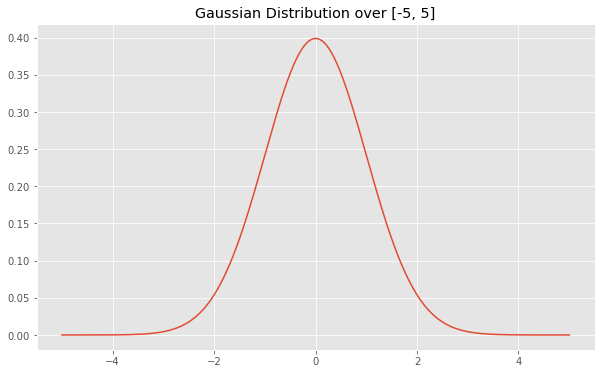

In [61]:
# generate 1000 evently distributed values in range [-5, 5]
x = np.linspace(-5, 5, num=1000)

# plot results of the Gaussian function over x
plt.figure(figsize=(10, 6))
plt.plot(x, gaussian(x, 0, 1))
plt.title("Gaussian Distribution over [-5, 5]")
plt.show()

We don't actually have to write our function to do this (though it's nice to get in-depth understanding of how to). Let's use `scipy.stats` instead. 

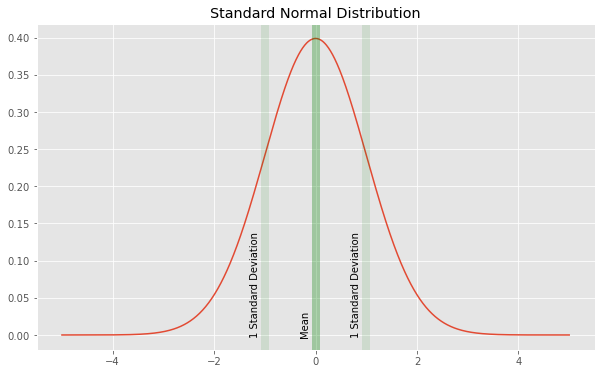

In [272]:
# generate 1000 evently distributed values in range [-5, 5]
x = np.linspace(-5, 5, num=1000)


# plot results of the Gaussian function over x
plt.figure(figsize=(10, 6))
plt.plot(x, stats.norm(0, 1).pdf(x))
plt.axvline(0, c='green', alpha=0.3, lw=8)
plt.annotate("Mean", (-0.3, 0), rotation=90)
plt.axvline(1, c='green', alpha=0.1, lw=8)
plt.annotate("1 Standard Deviation", (0.7, 0), rotation=90)
plt.axvline(-1, c='green', alpha=0.1, lw=8)
plt.annotate("1 Standard Deviation", (-1.3, 0), rotation=90)
plt.title("Standard Normal Distribution")
plt.show()

If we define an anomaly as a rare event, then we can use the probability density function to determine a threshold for an anomaly. If the probability of our event happens to be lower than our threshold, the event can be considered a potential anomaly. 

Then, for a multivariate problem, we can multiply probabilities of all variables together to get the final probability of our event. If our event is unlikely, then it will be an outlier for at least one feature and if it is an outlier for many features, the result will near 0. 

Let's take a look at an example with two variables. Let's define our distribution $f(x_1, x_2)$ to be the product of both probability density functions: $f_1(x_1)$ and $f_2(x_2)$. We assume that $x_1$ and $x_2$ are completely independent and have no correlation. Then, 
$$
\begin{align}
f(x_1, x_2) & = f_1(x_1) \; f_2(x_2) \\
& = \frac{1}{\sigma_1 \sqrt{2\pi}} \; \mathrm{exp}\bigg(-\frac{1}{2} \bigg( \frac{x_1-\mu_1}{\sigma_1} \bigg)^2 \bigg)
    \frac{1}{\sigma_2 \sqrt{2\pi}} \; \mathrm{exp}\bigg(-\frac{1}{2} \bigg( \frac{x_2-\mu_2}{\sigma_2} \bigg)^2 \bigg) \\
& = \frac{1}{2\pi \; \sigma_1 \sigma_2}  \; 
    \mathrm{exp}\bigg( \frac{1}{4} \bigg( \frac{x_1-\mu_1}{\sigma_1} \bigg)^2 \bigg( \frac{x_2-\mu_2}{\sigma_2} \bigg)^2  \bigg)
\end{align}
$$

However, we can't assume that the two distributions are totally uncorrelated and we should find their coefficient of correlation and account for it. If we assume that the two distribution are correlated, we can define their correlation coefficient as $\rho$. In the bivarirate and multivariate cases, we must not assume that the distribution may be correlated with correlation coefficient of $\rho$. If $x_1$ and $x_2$ are not correlated, then $\rho = 0$ and $f(x_1, x_2) = f_1(x_1) \; f_2(x_2)$. Otherwise, 

$$
f(x_1, x_2) = \frac{1}{2\pi \sqrt{1-\rho^2} \sigma_1 \sigma_2} 
                \mathrm{exp} \bigg( -\frac{1}{2 (1-\rho^2)} \bigg[ 
                    \bigg( \frac{x_1 - \mu_1}{\sigma_1} \bigg)^2  - 2\rho \bigg( \frac{x_1 - \mu_1}{\sigma_1} \bigg) \bigg( \frac{x_2 - \mu_2}{\sigma_2} \bigg) + \bigg( \frac{x_2 - \mu_2}{\sigma_2} \bigg)^2
                    \bigg]
                \bigg)
$$


Whew! I'm not going to prove it but these wonderful [lecture slides](https://www2.stat.duke.edu/courses/Spring12/sta104.1/Lectures/Lec22.pdf) from Duke university have a detailed derivation of bivariate and multivaraite cases. 

And the multivariate case looks like this:

$$
f(x_1, ..., x_n) = \frac{-(\mathbf{x} - \bm{\mu})^\mathrm{T} \mathbf{\Sigma}^{-1} (\mathbf{x} - \bm{\mu})}{\sqrt{(2 \pi)^n | \mathbf{\Sigma} |}}
$$

In [2]:
# generate 100 random features from normal distribution and 5 "anomalies" from uniform distribution 
x1 = np.concatenate([np.random.normal(10, 5, size=100)])
x2 = np.concatenate([np.random.normal(18, 2, size=100)])

# calculate actual means and standard deviations from our feature sets
means = np.mean([x1, x2], axis=1)
stdevs = np.std([x1, x2], axis=1)

# create a multivariate distribution given our means and standard deviations
dist = stats.multivariate_normal(means, stdevs)

# add anomalies to the dataset (points that would not be in the normal distribution)
x1 = np.append(x1, [1, 1.5, 20, 21, 19])
x2 = np.append(x2, [25, 3, 2.1, 7, 3])

# calculate probability density values for our features
proba = dist.pdf(np.array([x1, x2]).T)

/var/folders/1p/thxtrrfx3cb00_953mprmb2h0000gn/T/ipykernel_63363/351110233.py:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


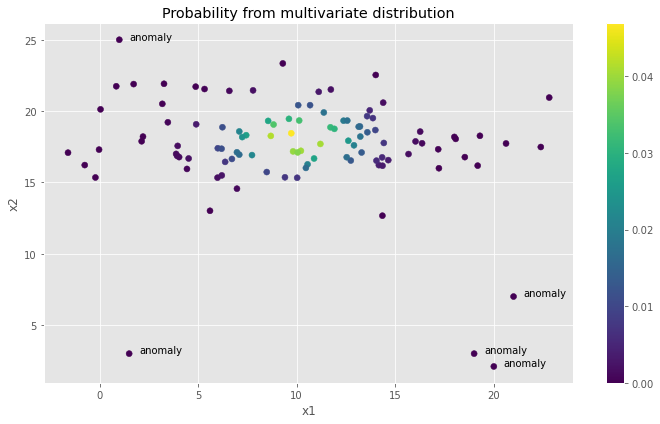

In [5]:
plt.figure(figsize=(10, 6))
plt.scatter(x1, x2, c=proba)
plt.title(f"Probability from multivariate distribution")
plt.xlabel("x1")
plt.ylabel("x2")
for i in range(5):
    plt.annotate("anomaly", (x1[-(i+1)]+0.5, x2[-(i+1)]))
plt.colorbar()
plt.tight_layout()
plt.show()

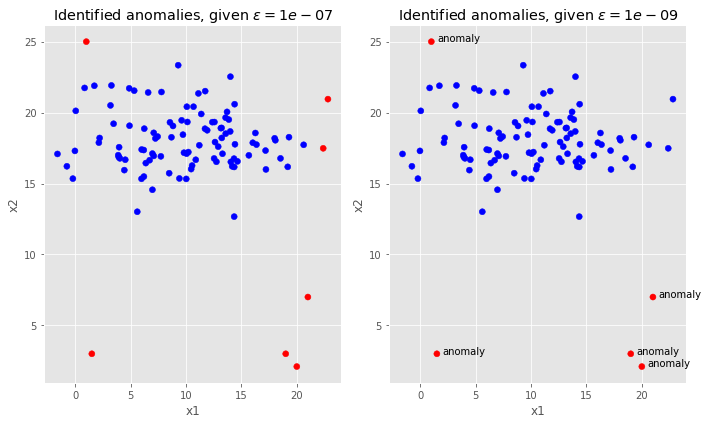

In [19]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))

eps = 1e-7
ax1.scatter(x1, x2, c=np.where(proba<eps, "red", "blue"))
ax1.title.set_text(f"Identified anomalies, given $\epsilon = {eps}$")
ax1.set_xlabel("x1")
ax1.set_ylabel("x2")

eps = 1e-9
ax2.scatter(x1, x2, c=np.where(proba<eps, "red", "blue"))
ax2.title.set_text(f"Identified anomalies, given $\epsilon = {eps}$")
ax2.set_xlabel("x1")
ax2.set_ylabel("x2")

for i in range(5):
    plt.annotate("anomaly", (x1[-(i+1)]+0.5, x2[-(i+1)]))
plt.tight_layout()
plt.show()

Let's explore a real dataset. 

Saket Sathe and Charu C. Aggarwal. LODES: Local Density meets Spectral Outlier Detection. SIAM Conference on Data Mining, 2016.   
Aeberhard,Stefan and Forina,M.. (1991). Wine. UCI Machine Learning Repository. https://doi.org/10.24432/C5PC7J.

In [211]:
# upload the datafile 
# http://odds.cs.stonybrook.edu/wine-dataset/
# Saket Sathe and Charu C. Aggarwal. LODES: Local Density meets Spectral Outlier Detection. SIAM Conference on Data Mining, 2016.
wine = loadmat('wine.mat')

# grab the features and create a dataframe
columns = ["alcohol", "malicacid", "ash", "alcalinity_of_ash", "magnesium",
          "total_phenols", "flavanoids", "nonflanoid_phenols", "proanthocyanins",
          "color_intensity", "hue", "0D280_0D315_of_diluted_wines", "proline"]

df = pd.DataFrame(wine["X"])
df.columns = columns

# anomaly targets
y_true = wine["y"].flatten()

# include features that follow a normal distribution
# this is tested using the Shapiro-Wilk test for normality
features = [c for c in columns if stats.shapiro(df[c]).pvalue >= 0.01] 

# log scale columns to normalize them
for c in ['total_phenols', 'proanthocyanins', 'color_intensity', 'hue']:
    df[c] = np.log(df[c]+1)
    features.append(c)

# identify outliers and exclude them from the training set
df['outlier'] = 0
for f in features:
    df['outlier'] += ((df[f] > df[f].mean()+2*df[f].std()) | (df[f] < df[f].mean() - 2*df[f].std())).astype(int)

df_train = df[df['outlier']==0]

# create a multivariate distribution given our means and standard deviations
dist = stats.multivariate_normal(df_train[features].mean().to_numpy(), df_train[features].std().to_numpy())

# calculate probability density values for our features for ALL values
proba = dist.pdf(df[features].to_numpy())


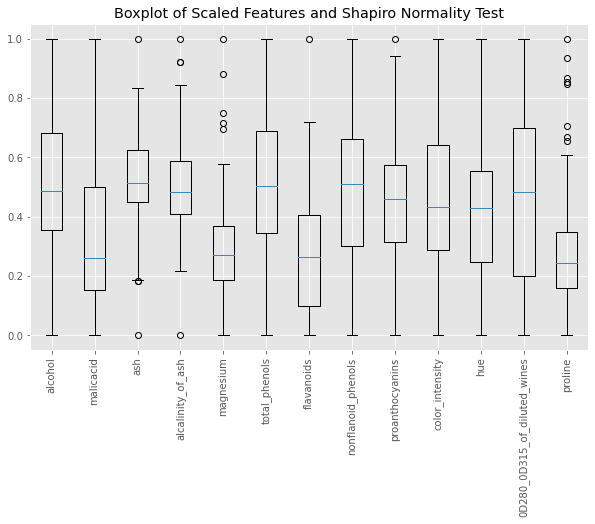

In [128]:
plt.figure(figsize=(10, 6))
plt.boxplot(minmax_scale(df[columns]))
plt.xticks(ticks=list(range(1, len(columns)+1)), labels=columns, rotation=90)
plt.title("Boxplot of Scaled Features and Shapiro Normality Test")
plt.show()


In [225]:
# evaluate the model with different epsilon values

eps = np.linspace(0.001, 0.01, 21)
recall = []
precision = []
auc = []

for e in eps:
    y_pred = np.where(proba < e, 1, 0)
    recall.append(recall_score(y_true, y_pred))
    precision.append(precision_score(y_true, y_pred))
    auc.append(roc_auc_score(y_true, y_pred))

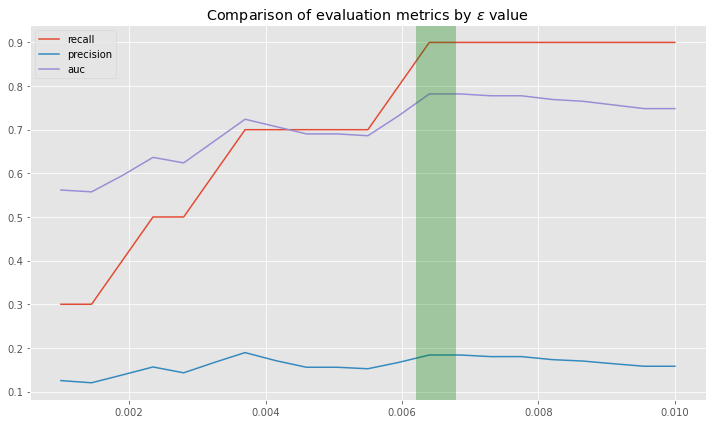

In [226]:
plt.figure(figsize=(10, 6))
plt.plot(eps, recall, label='recall')
plt.plot(eps, precision, label='precision')
plt.plot(eps, auc, label='auc')
plt.axvline(0.0065, c='green', alpha=0.3, lw=40)
plt.title('Comparison of evaluation metrics by $\epsilon$ value')
plt.legend()
plt.tight_layout()
plt.show()

Let's set epsilon to 0.0065 and calculate the confusion matrix

In [277]:
y_pred = np.where(proba < 0.0065, 1, 0)

cm = pd.DataFrame(confusion_matrix(y_true, y_pred), 
                  columns=['Predicted Positive', 'Predicted Anomaly'], 
                  index=['True Positive', 'True Anomaly'])

print(tabulate(cm, headers='keys', tablefmt='fancy_grid'))


╒═══════════════╤══════════════════════╤═════════════════════╕
│               │   Predicted Positive │   Predicted Anomaly │
╞═══════════════╪══════════════════════╪═════════════════════╡
│ True Positive │                   79 │                  40 │
├───────────────┼──────────────────────┼─────────────────────┤
│ True Anomaly  │                    1 │                   9 │
╘═══════════════╧══════════════════════╧═════════════════════╛
